In [ ]:
# Numerics for "Fast Thermalization from the Eigenstate Thermalization Hypothesis"
# by Chi-Fang Chen and Fernando Brandao.

# This code tests the expander properties at nearby energies of a chaotic spin chain. 
# We can diagonalize the Hamiltonian and compute the gap of the Lindbladian, up to ~ 12 qubits.

In [9]:
import numpy as np
from numpy import linalg as LA
from numpy import ndarray
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Latex syntax in Matplotlib
plt.rcParams['text.usetex'] = True

# Pauli matrices
Sx=np.array([
[0, 1],
[1, 0]])
Sy=np.array([
[0, 1j],
[-1j, 0]])
Sz=np.array([
[1, 0],
[0, -1]])
I2 = np.array([
[1, 0],
[0, 1]])

In [10]:
# Building up local operators from tensor products

# The identity 
def Id_tensor(i):
    M= np.array([[1]])
    for j in range(0,i):
        M = np.kron(M, I2)     
    return M

# The single site (1-local) operator S_i 
def tensor(S,i,L1):
    M= np.kron(Id_tensor(i-1),S)
    M= np.kron(M, Id_tensor(L1-i))
    return M

# The 2-local operator S_i S_j
def tensor2(S1,S2,i,j,L1):
    M= np.kron(Id_tensor(i-1),S1)
    M= np.kron(M, Id_tensor(j-i-1))
    M= np.kron(M, S2)
    M= np.kron(M, Id_tensor(L1-j))
    return M

# The 3-local operator S_i S_j S_k
def tensor3(S1,S2,S3,i,j,k,L1):
    M= np.kron(Id_tensor(i-1),S1)
    M= np.kron(M, Id_tensor(j-i-1))
    M= np.kron(M, S2)
    M= np.kron(M, Id_tensor(k-j-1))
    M= np.kron(M, S3)
    M= np.kron(M, Id_tensor(L1-k))
    return M

In [11]:
# The eigenvectors at energies between nu1 and nu11
def Pnu(nu1, nu11 ,w,v):
    ind_1=len(w)-1
    ind_2 = len(w)
    for j in range(0,len(w)-1):
        if j ==0 and nu1 < w[0]:
            ind_1 = 0
        if w[j] < nu1 and w[j+1] >= nu1:
            ind_1 = j+1
        if w[j] < nu11 and w[j+1] >= nu11:
            ind_2 = j+1            
    return v[ : , ind_1: ind_2]

# The diagonal superprojector:
# P: M_{ij} -> \delta_{ij} M_{ij}
def superP_diag(d):
    I= np.identity(d)
    P = 0*np.kron( I,I)
    for i in range(0,d):
        P[i* d+i][i* d+i] = 1
    return P

In [12]:
# The eigenvalues of the Lindbladian
#######

# The spectrum of the Lindbaldian (with diagonal inputs): 
# L_diag := A21 X A12 + A12 X A21 - 1/2 ( A21 A12 X + X A12 A21 ),
# where A12 := A21^†
def spec_Lind_expand12(A21):
    I2=np.identity(A21[0].shape[0])
    I1=np.identity(A21[0].shape[1])
    b=0
    for B in A21:
        Bc=B.conj()
        if(b==0): 
            M21 = np.kron(B,Bc)
            b=1
        else:
            M21 = M21 + np.kron(B,Bc)
    b=0
    for B in A21:
        Bc=B.conj()
        BH=Bc.T
        if(b==0): 
            M11 = -0.5* np.kron(BH.dot(B), I1) - 0.5*np.kron(I1,BH.dot(B).T)
            b=1
        else:
            M11 = M11 -0.5* np.kron(BH.dot(B), I1) - 0.5*np.kron(I1,BH.dot(B).T)
    b=0
    for B in A21:
        Bc=B.conj()
        BH=Bc.T
        if(b==0): 
            M22 = -0.5* np.kron(B.dot(BH), I2) - 0.5*np.kron(I2,(B.dot(BH)).T)
            b=1
        else:
            M22 = M22 -0.5* np.kron(B.dot(BH), I2) - 0.5*np.kron(I2,(B.dot(BH)).T)
            
    M = np.hstack( (np.vstack((M22,M21.conj().T)), np.vstack((M21,M11)) ) )
    return LA.eigvalsh(-M)


# The spectrum of the "expected" Lindbaldian (with diagonal inputs): 
# E [L_diag].
# The expectation is supposedly taken over ETH, but here we model it by drop zero mean terms manually.
def Exp_Lind_expand12(A21):
    I2=np.identity(A21[0].shape[0])
    I1=np.identity(A21[0].shape[1])
    b=0
    for B in A21:
        Bc=B.conj()
        if(b==0): 
            M21 = np.kron(B,Bc)
            b=1
        else:
            M21 = M21 + np.kron(B,Bc)
    b=0
    for B in A21:
        Bc=B.conj()
        BH=Bc.T
        if(b==0): 
            M11 = -0.5* np.kron(BH.dot(B)*I1, I1) - 0.5*np.kron(I1,BH.dot(B).T*I1)
            b=1
        else:
            M11 = M11 -0.5* np.kron(BH.dot(B)*I1, I1) - 0.5*np.kron(I1,BH.dot(B).T*I1)
    b=0
    for B in A21:
        Bc=B.conj()
        BH=Bc.T
        if(b==0): 
            M22 = -0.5* np.kron(B.dot(BH)*I2, I2) - 0.5*np.kron(I2,(B.dot(BH)).T*I2)
            b=1
        else:
            M22 = M22 -0.5* np.kron(B.dot(BH)*I2, I2) - 0.5*np.kron(I2,(B.dot(BH)).T*I2)
            
    M = np.hstack( (np.vstack((M22,M21.conj().T)), np.vstack((M21,M11)) ) )
    return LA.eigvalsh(-M)[1]


# The superoperator 2-2 norm of the deviation (with diagonal inputs): 
# L_diag - E[L_diag] 

def delta_spec_Lind_expand12(A21):
    I2=np.identity(A21[0].shape[0])
    I1=np.identity(A21[0].shape[1])
    sP2=superP_diag(A21[0].shape[0])
    sP1=superP_diag(A21[0].shape[1])
    b=0
    for B in A21:
        Bc=B.conj()
        if(b==0): 
            M21 = np.kron(B,Bc)
            b=1
        else:
            M21 = M21 + np.kron(B,Bc)
    M21 = M21 - sP2.dot(M21).dot(sP1)
    
    b=0
    for B in A21:
        Bc=B.conj()
        BH=Bc.T
        if(b==0): 
            M11 = -0.5* np.kron(BH.dot(B), I1) - 0.5*np.kron(I1,BH.dot(B).T) + 0.5* np.kron(BH.dot(B)*I1, I1) + 0.5*np.kron(I1,BH.dot(B).T*I1)
            b=1
        else:
            M11 = M11 -0.5* np.kron(BH.dot(B), I1) - 0.5*np.kron(I1,BH.dot(B).T)+0.5* np.kron(BH.dot(B)*I1, I1) + 0.5*np.kron(I1,BH.dot(B).T*I1)

    b=0
    for B in A21:
        Bc=B.conj()
        BH=Bc.T
        if(b==0): 
            M22 = -0.5* np.kron(B.dot(BH), I2) - 0.5*np.kron(I2,(B.dot(BH)).T)+0.5* np.kron(B.dot(BH)*I2, I2) + 0.5*np.kron(I2,(B.dot(BH)).T*I2)
            b=1
        else:
            M22 = M22 -0.5* np.kron(B.dot(BH), I2) - 0.5*np.kron(I2,(B.dot(BH)).T)+0.5* np.kron(B.dot(BH)*I2, I2) + 0.5*np.kron(I2,(B.dot(BH)).T*I2)

    
    M = np.hstack( (np.vstack((M22,M21.conj().T)), np.vstack((M21,M11)) ) )
    u,s,vh = LA.svd(M)
    return s[0] # largest singular value


# The spectrum of the Lindbaldian (with off-diagonal inputs): 
# L_off := A21 X A_1_2 + A_2_1 X A12  - 1/2 ( A21 A12 X + X A_1_2 A_2_1 ),
# where A_1_2 := A_2_1^†

def spec_offdiag_Lind_expand12(A21,A_2_1):
    I2=np.identity(A21[0].shape[0])
    I1=np.identity(A21[0].shape[1])
    I_2=np.identity(A_2_1[0].shape[0])
    I_1=np.identity(A_2_1[0].shape[1])
    
    b=0
    for i in range(0,len(A21)):
        B=A21[i]
        Bc=A_2_1[i].conj()
        if(b==0): 
            M21 = np.kron(B,Bc)
            b=1
        else:
            M21 = M21 + np.kron(B,Bc)
            
    b=0
    for i in range(0,len(A21)):
        B = A21[i]
        BH=B.T.conj()
        B_ = A_2_1[i]
        B_H = B_.T.conj()
        if(b==0): 
            M11 = -0.5* np.kron(BH.dot(B), I_1) - 0.5*np.kron(I1,B_H.dot(B_))
            b=1
        else:
            M11 = M11 -0.5* np.kron(BH.dot(B), I_1) - 0.5*np.kron(I1,B_H.dot(B_))
            
    b=0
    for i in range(0,len(A21)):
        B = A21[i]
        BH=B.T.conj()
        B_ = A_2_1[i]
        B_H = B_.T.conj()
        if(b==0): 
            M22 = -0.5* np.kron(B.dot(BH), I_2) - 0.5*np.kron(I2,B_.dot(B_H))
            b=1
        else:
            M22 = M22 -0.5* np.kron(B.dot(BH), I_2) - 0.5*np.kron(I2,B_.dot(B_H))
            
    M = np.hstack( (np.vstack((M22,M21.conj().T)), np.vstack((M21,M11)) ) )
    return LA.eigvalsh(-M)



# The spectrum of the "expected" Lindbaldian (with off-diagonal inputs):
# E [ L_off ]
# Again, zero mean terms are dropped manually to model the expectation.


def Exp_offdiag_Lind_expand12(A21,A_2_1):
    I2=np.identity(A21[0].shape[0])
    I1=np.identity(A21[0].shape[1])
    I_2=np.identity(A_2_1[0].shape[0])
    I_1=np.identity(A_2_1[0].shape[1])

    B = A21[0]
    Bc = A_2_1[0].conj()
    M21 = 0*np.kron(B,Bc)
            
    b=0
    for i in range(0,len(A21)):
        B = A21[i]
        BH=B.T.conj()
        B_ = A_2_1[i]
        B_H = B_.T.conj()
        if(b==0): 
            M11 = -0.5* np.kron(BH.dot(B)*I1, I_1) - 0.5*np.kron(I1,B_H.dot(B_)*I_1)
            b=1
        else:
            M11 = M11 -0.5* np.kron(BH.dot(B)*I1, I_1) - 0.5*np.kron(I1,B_H.dot(B_)*I_1)
            
    b=0
    for i in range(0,len(A21)):
        B = A21[i]
        BH=B.T.conj()
        B_ = A_2_1[i]
        B_H = B_.T.conj()
        if(b==0): 
            M22 = -0.5* np.kron(B.dot(BH)*I2, I_2) - 0.5*np.kron(I2,B_.dot(B_H)*I_2)
            b=1
        else:
            M22 = M22 -0.5* np.kron(B.dot(BH)*I2, I_2) - 0.5*np.kron(I2,B_.dot(B_H)*I_2)
            
    M = np.hstack( (np.vstack((M22,M21.conj().T)), np.vstack((M21,M11)) ) )
    return LA.eigvalsh(-M)


# The superoperator 2-2 norm of the deviation (with off-diagonal inputs):
# L_off - E[L_off]

def delta_spec_offdiag_Lind_expand12(A21,A_2_1):
    I2=np.identity(A21[0].shape[0])
    I1=np.identity(A21[0].shape[1])
    I_2=np.identity(A_2_1[0].shape[0])
    I_1=np.identity(A_2_1[0].shape[1])
    
    b=0
    for i in range(0,len(A21)):
        B=A21[i]
        Bc=A_2_1[i].conj()
        if(b==0): 
            M21 = np.kron(B,Bc)
            b=1
        else:
            M21 = M21 + np.kron(B,Bc)
            
    b=0
    for i in range(0,len(A21)):
        B = A21[i]
        BH=B.T.conj()
        B_ = A_2_1[i]
        B_H = B_.T.conj()
        if(b==0): 
            M11 = -0.5* np.kron(BH.dot(B), I_1) - 0.5*np.kron(I1,B_H.dot(B_)) + 0.5* np.kron(BH.dot(B)*I1, I_1) + 0.5*np.kron(I1,B_H.dot(B_)*I_1)
            b=1
        else:
            M11 = M11 -0.5* np.kron(BH.dot(B), I_1) - 0.5*np.kron(I1,B_H.dot(B_))+0.5* np.kron(BH.dot(B)*I1, I_1) + 0.5*np.kron(I1,B_H.dot(B_)*I_1)
            
    b=0
    for i in range(0,len(A21)):
        B = A21[i]
        BH=B.T.conj()
        B_ = A_2_1[i]
        B_H = B_.T.conj()
        if(b==0): 
            M22 = -0.5* np.kron(B.dot(BH), I_2) - 0.5*np.kron(I2,B_.dot(B_H))+ 0.5* np.kron(B.dot(BH)*I2, I_2) + 0.5*np.kron(I2,B_.dot(B_H)*I_2)
            b=1
        else:
            M22 = M22 -0.5* np.kron(B.dot(BH), I_2) - 0.5*np.kron(I2,B_.dot(B_H))+ 0.5* np.kron(B.dot(BH)*I2, I_2) + 0.5*np.kron(I2,B_.dot(B_H)*I_2)
            
    M = np.hstack( (np.vstack((M22,M21.conj().T)), np.vstack((M21,M11)) ) )
    u,s,vh = LA.svd(M)
    return s[0]

In [13]:
#random Gaussian Hamiltonian
def gau_H(L):
    N=2**L
    H = 3/(N**0.5) * np.random.rand(N,N)+3*1j/(N**0.5) *np.random.rand(N,N)
    return H+ H.conj().T # hermitian constraint


# The nearest neighbor spin chain with L sites, with periodic boundary conditions
# H := \sum_i  g* Sx_i +h *Sz_i + J* Sz_i Sz_{i+1}

def ghHamiltonian(g,h,L):
    for j in range(0,L):
        if j==0:
            M1 = g * tensor(Sx,1,L)
            M2 = h  * tensor(Sz,1,L)
            M3 = J * tensor(Sz,L,L).dot(tensor(Sz,1,L))
        else:    
            M1= M1+ g * tensor(Sx,j+1,L)
            M2= M2+ h * tensor(Sz,j+1,L)
            M3= M3+ J * tensor2(Sz,Sz,j,j+1,L)        
    H = M1+M2+M3
    return H

In [7]:
########
########

In [ ]:
#Data below

In [ ]:
########
########

0.0, 0.4 20
1.0, 1.4 20
0.0, 0.4 29
1.0, 1.4 29
0.0, 0.4 64
1.0, 1.4 64
0.0, 0.4 123
1.0, 1.4 123


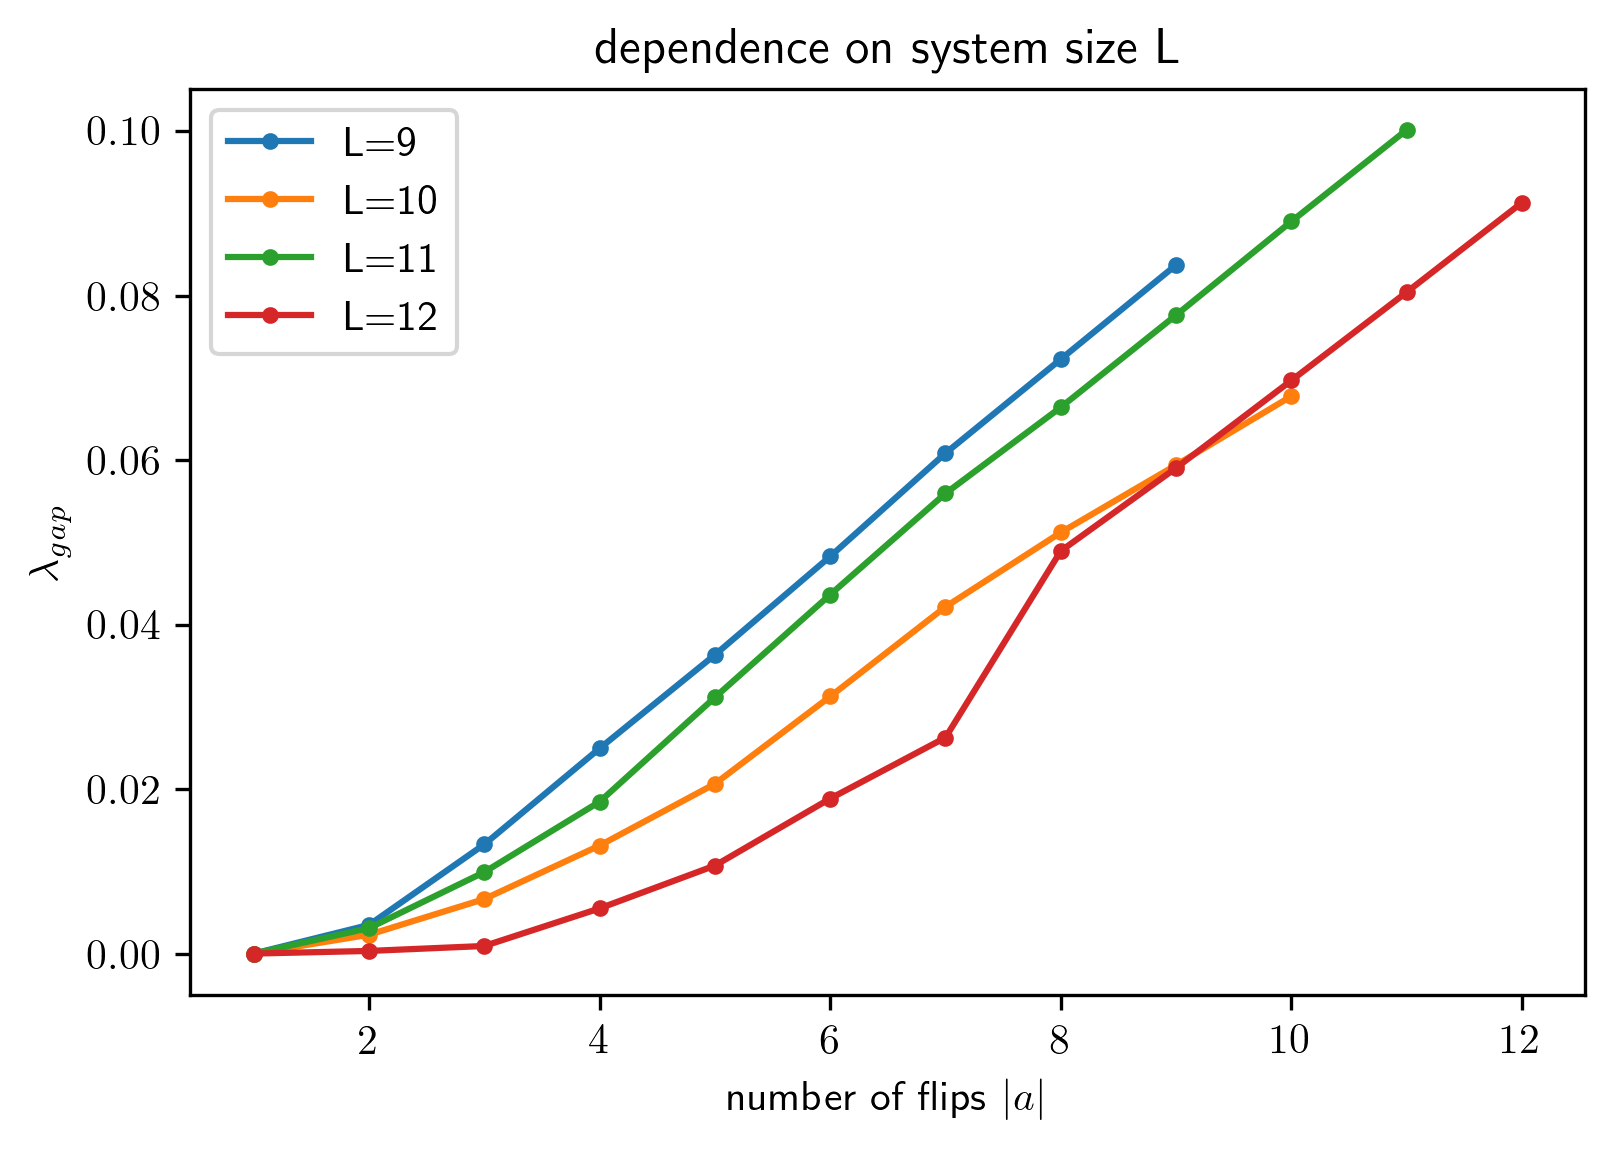

In [29]:
# System size dependence for the gap of the Lindbladian (with diagonal inputs):
# L_diag 

plt.figure(dpi=300)
for L in range (9,13):

    #parameters of H
    g1 = 0.9045  
    h1 = 0.8090 
    J = 1
    H = ghHamiltonian(g1,h1,L)
    
    nu0 = 0.4 # the energy resolution
    omega = 1 # the energy difference nu1 - nu2 
    nu1 = 0
    
    # the energy internals for A12:
    # [nu1, nu11], [nu2, nu22].
    nu11 = nu1+nu0
    nu2 = nu1 + omega
    nu22 = nu2+nu0
    w, v = LA.eigh( H )
    Pnu1 = Pnu(nu1,nu11,w,v)
    Pnu2 = Pnu(nu2,nu22,w,v)
    Pnu2H = Pnu2.conj().T
    print("%.1f, %.1f"  %(nu1,nu11), np.shape(Pnu1)[1]) # the dimension of projector for energies in [nu1,nu11]
    print("%.1f, %.1f"  %(nu2,nu22), np.shape(Pnu1)[1]) # in [nu2,nu22]

    aary = np.linspace(1,L,num=L)
    lam = np.zeros(len(aary))
    for k in range(0,len(aary)):
        a=int(aary[k])
        
        # Taking the flips to be Sx
        A21 =[Pnu2H.dot(tensor(Sx, i,L).dot(Pnu1)) for i in range(1,a+1)] 
        lam[k]=spec_Lind_expand12(A21)[1]
    plt.plot(aary,lam,'.-',label='L=%d'%L )

plt.legend()
plt.title("dependence on system size L")
plt.xlabel(r"number of flips $|a|$")
plt.ylabel(r"$\lambda_{gap}$")
plt.show()


-10.0, -9.6 11
-9.0, -8.6 16
-8.0, -7.6 27
-7.0, -6.6 31
-6.0, -5.6 33
-5.0, -4.6 49
-4.0, -3.6 45
-3.0, -2.6 59
-2.0, -1.6 65
-1.0, -0.6 60
0.0, 0.4 64
1.0, 1.4 57


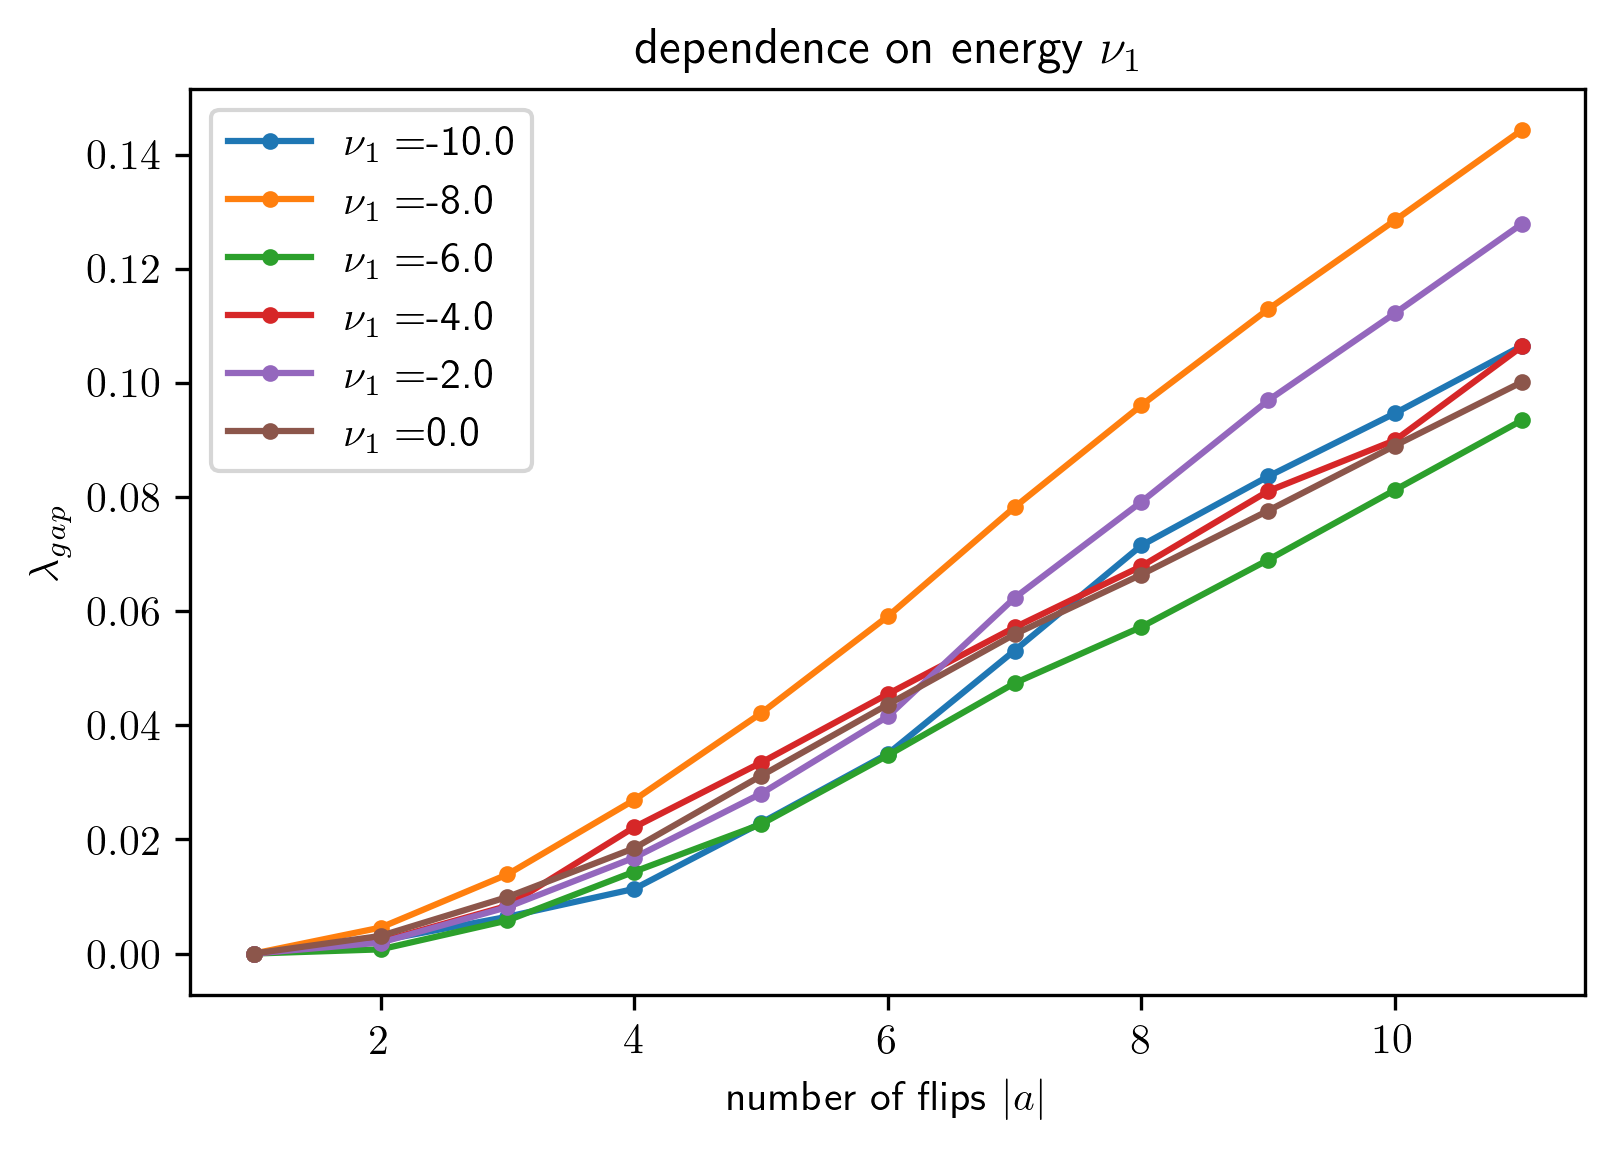

In [7]:
# Changing position bnu1
plt.figure(dpi=300)

g1 = 0.9045  
h1 = 0.8090 
J = 1
L = 11
H = ghHamiltonian(g1,h1,L)
w, v = LA.eigh( H )

nu0 = 0.4
omega = 1

for nu1 in [-10,-8,-6,-4,-2,0]:
    nu11 = nu1+nu0
    nu2 = nu1 + omega
    nu22 = nu2+nu0

    Pnu1 = Pnu( nu1,nu11,w,v)
    Pnu2 = Pnu(nu2,nu22,w,v)
    Pnu2H = Pnu2.conj().T
    print("%.1f, %.1f"  %(nu1,nu11), np.shape(Pnu1)[1])
    print("%.1f, %.1f"  %(nu2,nu22), np.shape(Pnu2)[1])
    
    aary = np.linspace(1,L,num=L)
    lam = np.zeros(len(aary))
    for k in range(0,len(aary)):
        a=int(aary[k])
        A21 =[Pnu2H.dot(tensor(Sx, i,L).dot(Pnu1)) for i in range(1,a+1)]
        lam[k]=spec_Lind_expand12(A21)[1]
    plt.plot(aary,lam,'.-',label=r'$\nu_1=$%.1f'%nu1 )

plt.legend()
plt.title(r"dependence on energy $\nu_1$")
plt.xlabel(r"number of flips $|a|$")
plt.ylabel(r"$\lambda_{gap}$")
plt.show()

0.0, 0.4 64
1.0, 1.4 57
0.0, 0.4 64
2.0, 2.4 54
0.0, 0.4 64
3.0, 3.4 55
0.0, 0.4 64
4.0, 4.4 39
0.0, 0.4 64
5.0, 5.4 34
0.0, 0.4 64
6.0, 6.4 25


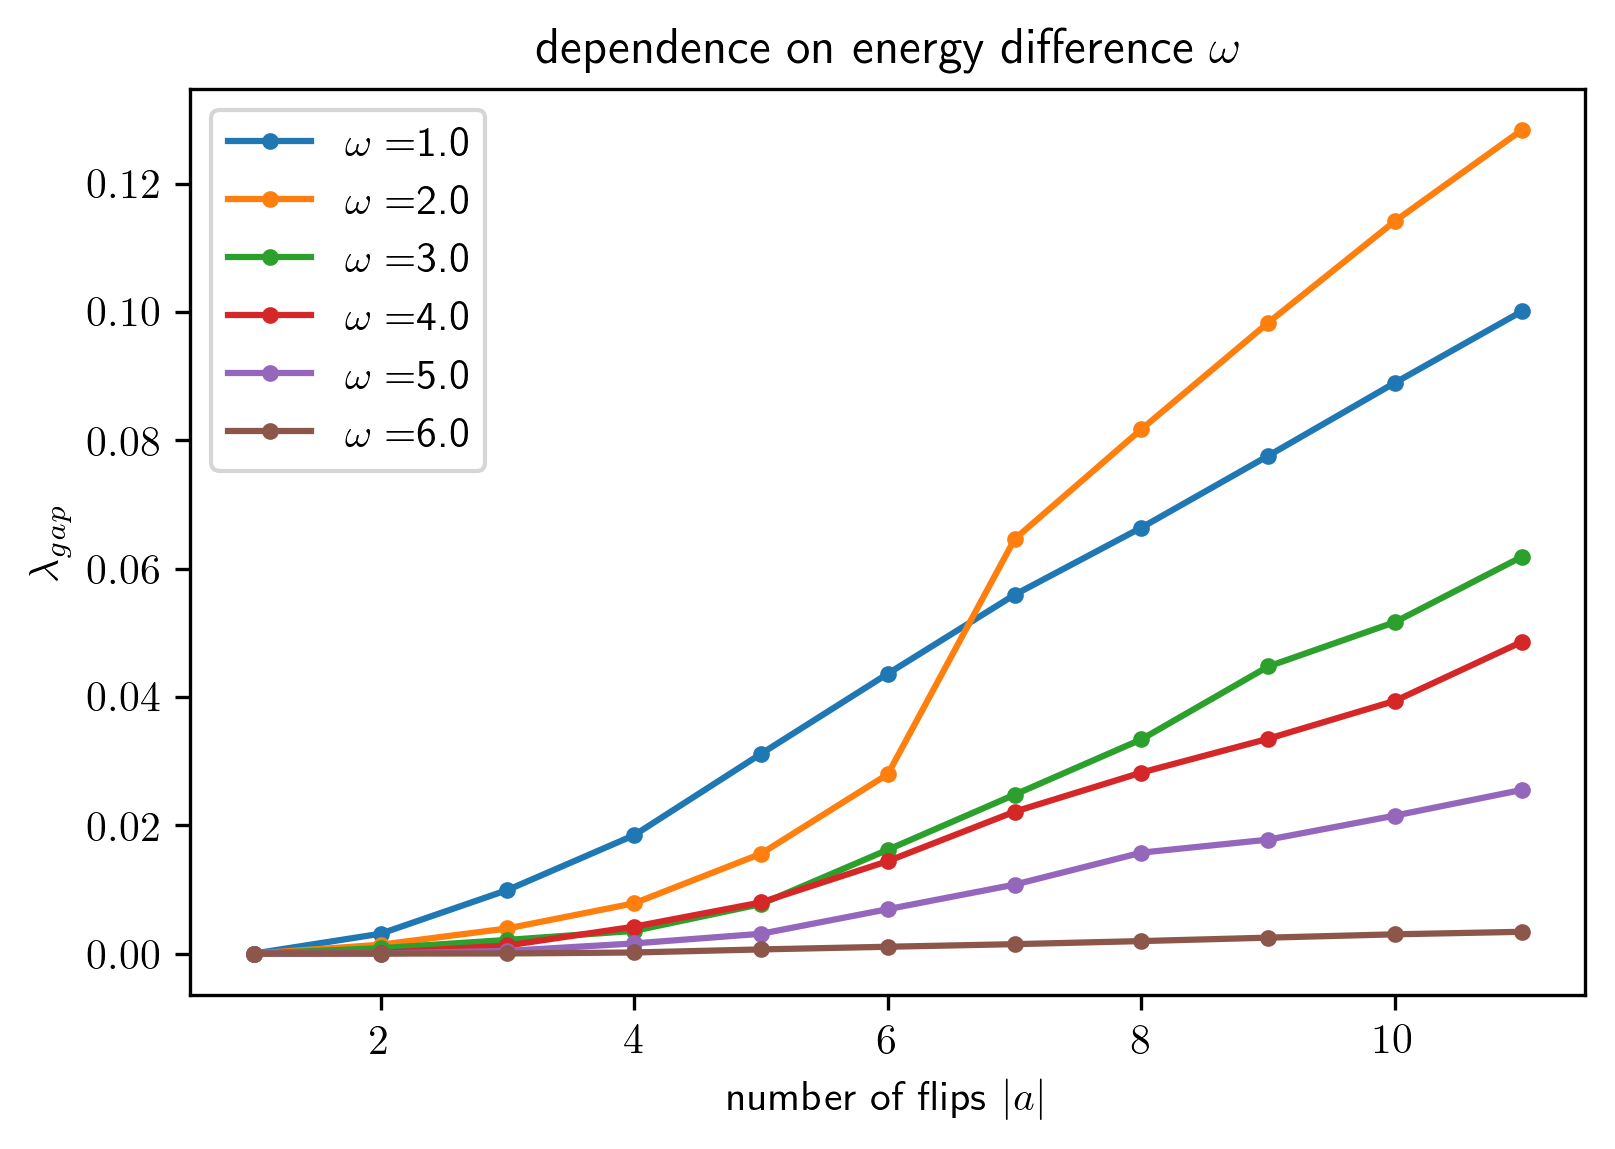

In [8]:
# Changing the energy difference omega
plt.figure(dpi=300)

g1 = 0.9045  
h1 = 0.8090 
J = 1
L = 11
H = ghHamiltonian(g1,h1,L)
w, v = LA.eigh( H )

nu0 = 0.4
nu1=0

for omega in [1, 2, 3, 4, 5, 6]:
    nu11 = nu1+nu0
    nu2 = nu1 + omega
    nu22 = nu2+nu0

    Pnu1 = Pnu( nu1,nu11,w,v)
    Pnu2 = Pnu(nu2,nu22,w,v)
    Pnu2H = Pnu2.conj().T
    print("%.1f, %.1f"  %(nu1,nu11), np.shape(Pnu1)[1])
    print("%.1f, %.1f"  %(nu2,nu22), np.shape(Pnu2)[1])
    
    aary = np.linspace(1,L,num=L)
    lam = np.zeros(len(aary))
    for k in range(0,len(aary)):
        a=int(aary[k])
        A21 =[Pnu2H.dot(tensor(Sx, i,L).dot(Pnu1)) for i in range(1,a+1)]
        lam[k]=spec_Lind_expand12(A21)[1]
    plt.plot(aary,lam,'.-',label=r'$\omega=$%.1f'%omega )

plt.legend()
plt.title(r"dependence on energy difference $\omega$")
plt.xlabel(r"number of flips $|a|$")
plt.ylabel(r"$\lambda_{gap}$")
plt.show()

In [ ]:
# k-body dependence

0.0, 0.4 64
1.0, 1.4 57


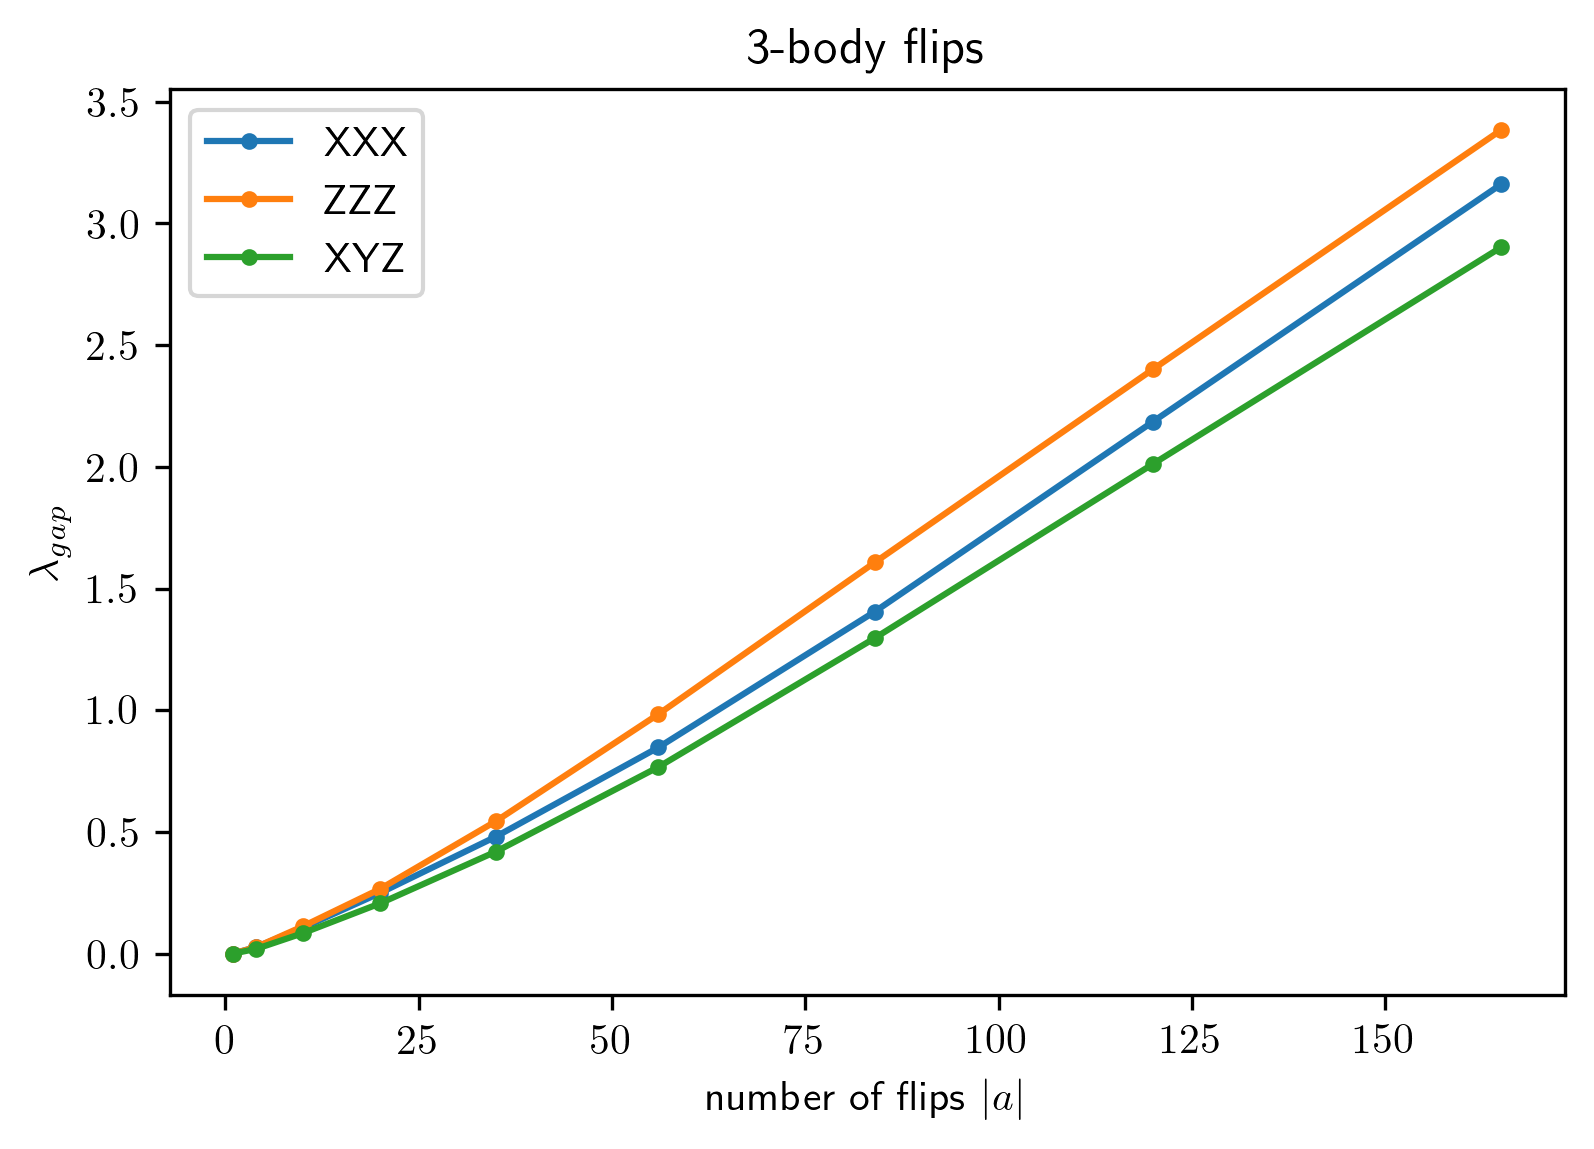

In [12]:
# 3-body 
plt.figure(dpi=300)

g1 = 0.9045  
h1 = 0.8090 
J = 1
L = 11
omega =1
H = ghHamiltonian(g1,h1,L)
w, v = LA.eigh( H )

nu0 = 0.4
nu1=0
nu11 = nu1+nu0
nu2 = nu1 + omega
nu22 = nu2+nu0


Pnu1 = Pnu( nu1,nu11,w,v)
Pnu2 = Pnu(nu2,nu22,w,v)
Pnu2H = Pnu2.conj().T
print("%.1f, %.1f"  %(nu1,nu11), np.shape(Pnu1)[1])
print("%.1f, %.1f"  %(nu2,nu22), np.shape(Pnu2)[1])

#XXX
aary = np.linspace(3,L,num=L-2)
lam = np.zeros(len(aary))
for k in range(0,len(aary)):
    a=int(aary[k])
    A21 =[Pnu2H.dot(tensor3(Sx,Sx,Sx, i, j,k,L).dot(Pnu1)) for i in range(1,a+1) for j in range(i+1,a+1) for k in range(j+1,a+1)]
    lam[k]=spec_Lind_expand12(A21)[1]
plt.plot(1/6*aary*(aary-1)*(aary-2),lam,'.-', label='XXX')

#ZZZ
aary = np.linspace(3,L,num=L-2)
lam = np.zeros(len(aary))
for k in range(0,len(aary)):
    a=int(aary[k])
    A21 =[Pnu2H.dot(tensor3(Sz,Sz,Sz, i, j,k,L).dot(Pnu1)) for i in range(1,a+1) for j in range(i+1,a+1) for k in range(j+1,a+1)]
    lam[k]=spec_Lind_expand12(A21)[1]
plt.plot(1/6*aary*(aary-1)*(aary-2),lam,'.-', label='ZZZ')

#XYZ
aary = np.linspace(3,L,num=L-2)
lam = np.zeros(len(aary))
for k in range(0,len(aary)):
    a=int(aary[k])
    A21 =[Pnu2H.dot(tensor3(Sx,Sy,Sz, i, j,k,L).dot(Pnu1)) for i in range(1,a+1) for j in range(i+1,a+1) for k in range(j+1,a+1)]
    lam[k]=spec_Lind_expand12(A21)[1]
plt.plot(1/6*aary*(aary-1)*(aary-2),lam,'.-', label='XYZ')

plt.legend()
plt.title("3-body flips")
plt.xlabel(r"number of flips $|a|$")
plt.ylabel(r"$\lambda_{gap}$")
plt.show()

In [ ]:
# Lindbladian with off-diagonal inputs.
# Here, we also need the extra parameter:
# omega_ 
# which quantifies how ``off-diagonal'' the inputs are.

0 0.4 20
1 1.4 19
3 3.4 14
4 4.4 12
0 0.4 29
1 1.4 28
3 3.4 26
4 4.4 20
0 0.4 64
1 1.4 57
3 3.4 55
4 4.4 39
0 0.4 123
1 1.4 112
3 3.4 97
4 4.4 87


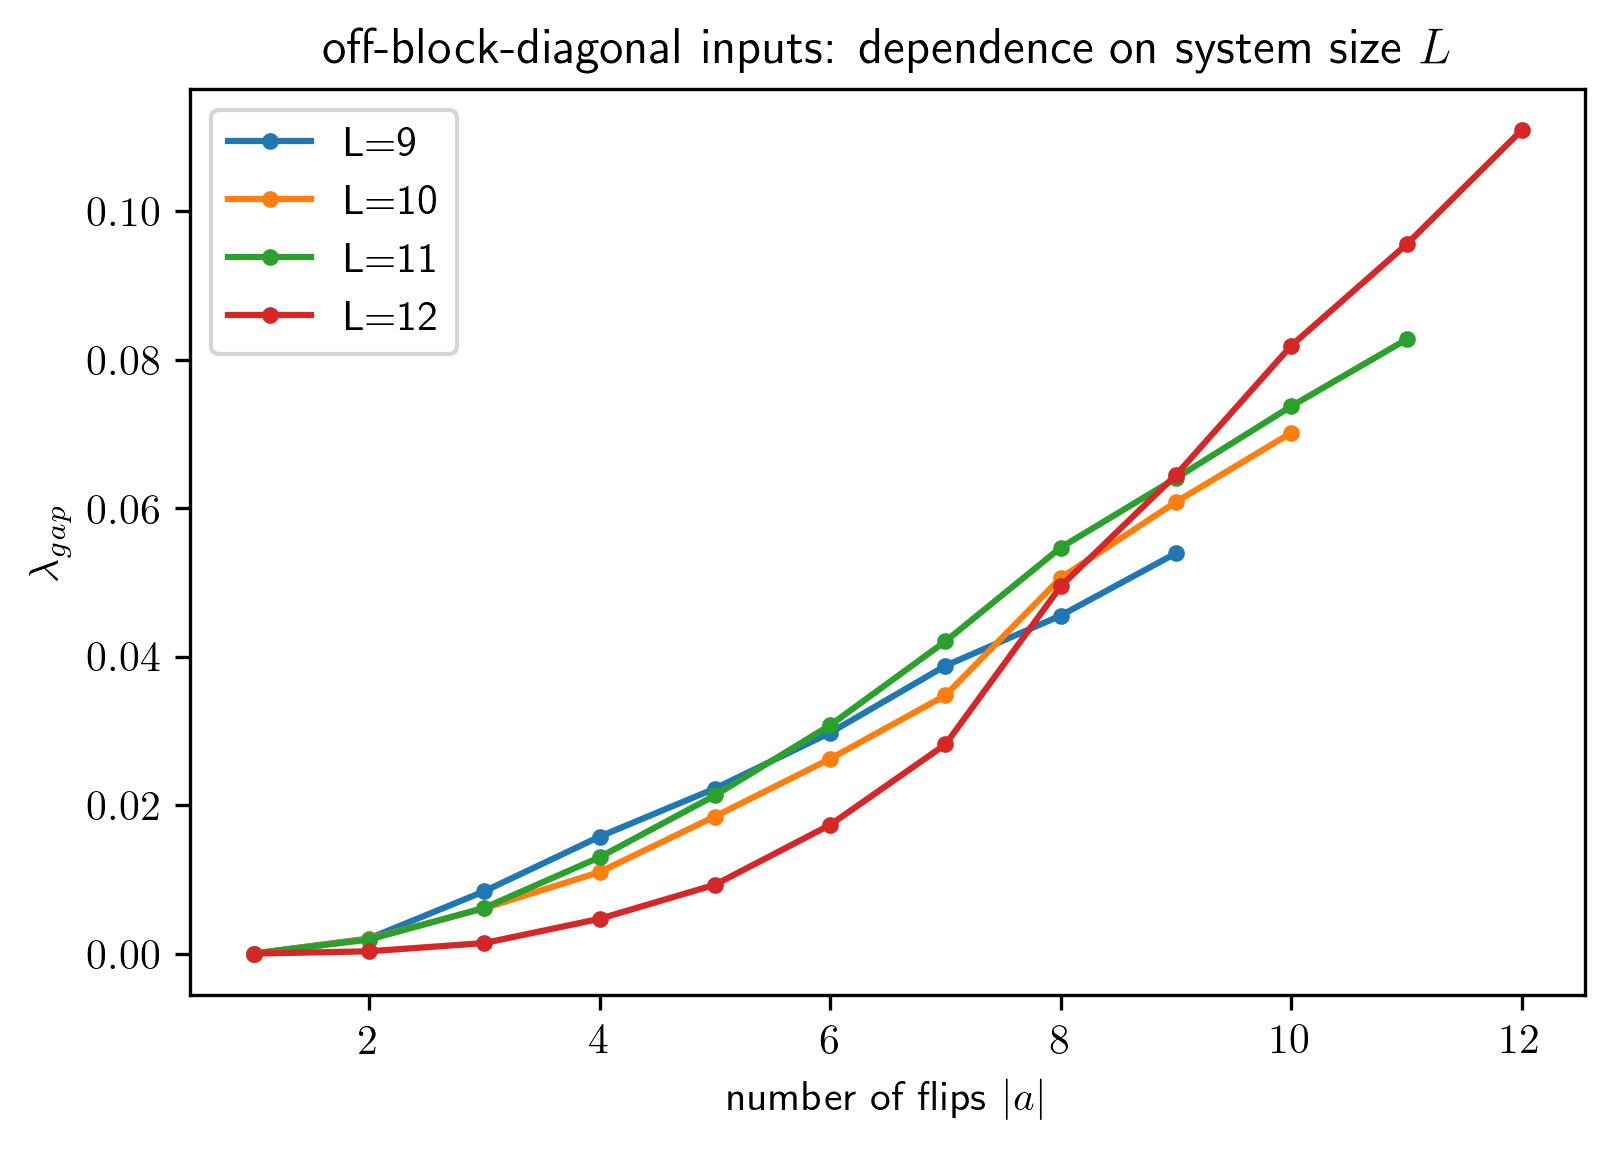

In [28]:
# Off-diagonal inputs: system size dependence
plt.figure(dpi=300)

for L in range (9,13):
    g1 = 0.9045  
    h1 = 0.8090 
    J = 1
    H = ghHamiltonian(g1,h1,L)

    nu0 = 0.4
    omega = 1
    omega_ = 3

# We need four energies to specify the off-diagonal input
    nu1 = 0
    nu11 = nu1+nu0
    nu2 = nu1 + omega
    nu22 = nu2+nu0

    nu_1 = nu1 +omega_
    nu_11 = nu_1+nu0
    nu_2 = nu_1+omega
    nu_22 = nu_2+nu0

    w, v = LA.eigh( H )
    Pnu1 = Pnu( nu1,nu11,w,v)
    Pnu2 = Pnu(nu2,nu22,w,v)
    Pnu2H = Pnu2.conj().T
    print(nu1,nu11, np.shape(Pnu1)[1])
    print(nu2,nu22, np.shape(Pnu2)[1])

    Pnu_1 = Pnu( nu_1,nu_11,w,v)
    Pnu_2 = Pnu(nu_2,nu_22,w,v)
    Pnu_2H = Pnu_2.conj().T    
    print(nu_1,nu_11, np.shape(Pnu_1)[1])
    print(nu_2,nu_22, np.shape(Pnu_2)[1])
    
    aary = np.linspace(1,L,num=L)
    lam = np.zeros(len(aary))
    for k in range(0,len(aary)):
        a=int(aary[k])
        A21 =[Pnu2H.dot(tensor(Sx, i,L).dot(Pnu1)) for i in range(1,a+1)]
        A_2_1 =[Pnu_2H.dot(tensor(Sx, i,L).dot(Pnu_1)) for i in range(1,a+1)]
        lam[k]=spec_offdiag_Lind_expand12(A21,A_2_1)[0]

    plt.plot(aary,lam,'.-', label='L=%d'%L)

plt.legend()
plt.title("off-block-diagonal inputs: dependence on system size $L$")
plt.xlabel(r"number of flips $|a|$")
plt.ylabel(r"$\lambda_{gap}$")
plt.show()

0 0.4 64
1 1.4 57
1 1.4 57
2 2.4 54
0 0.4 64
1 1.4 57
3 3.4 55
4 4.4 39
0 0.4 64
1 1.4 57
5 5.4 34
6 6.4 25
0 0.4 64
1 1.4 57
7 7.4 22
8 8.4 29
0 0.4 64
1 1.4 57
9 9.4 11
10 10.4 13
0 0.4 64
1 1.4 57


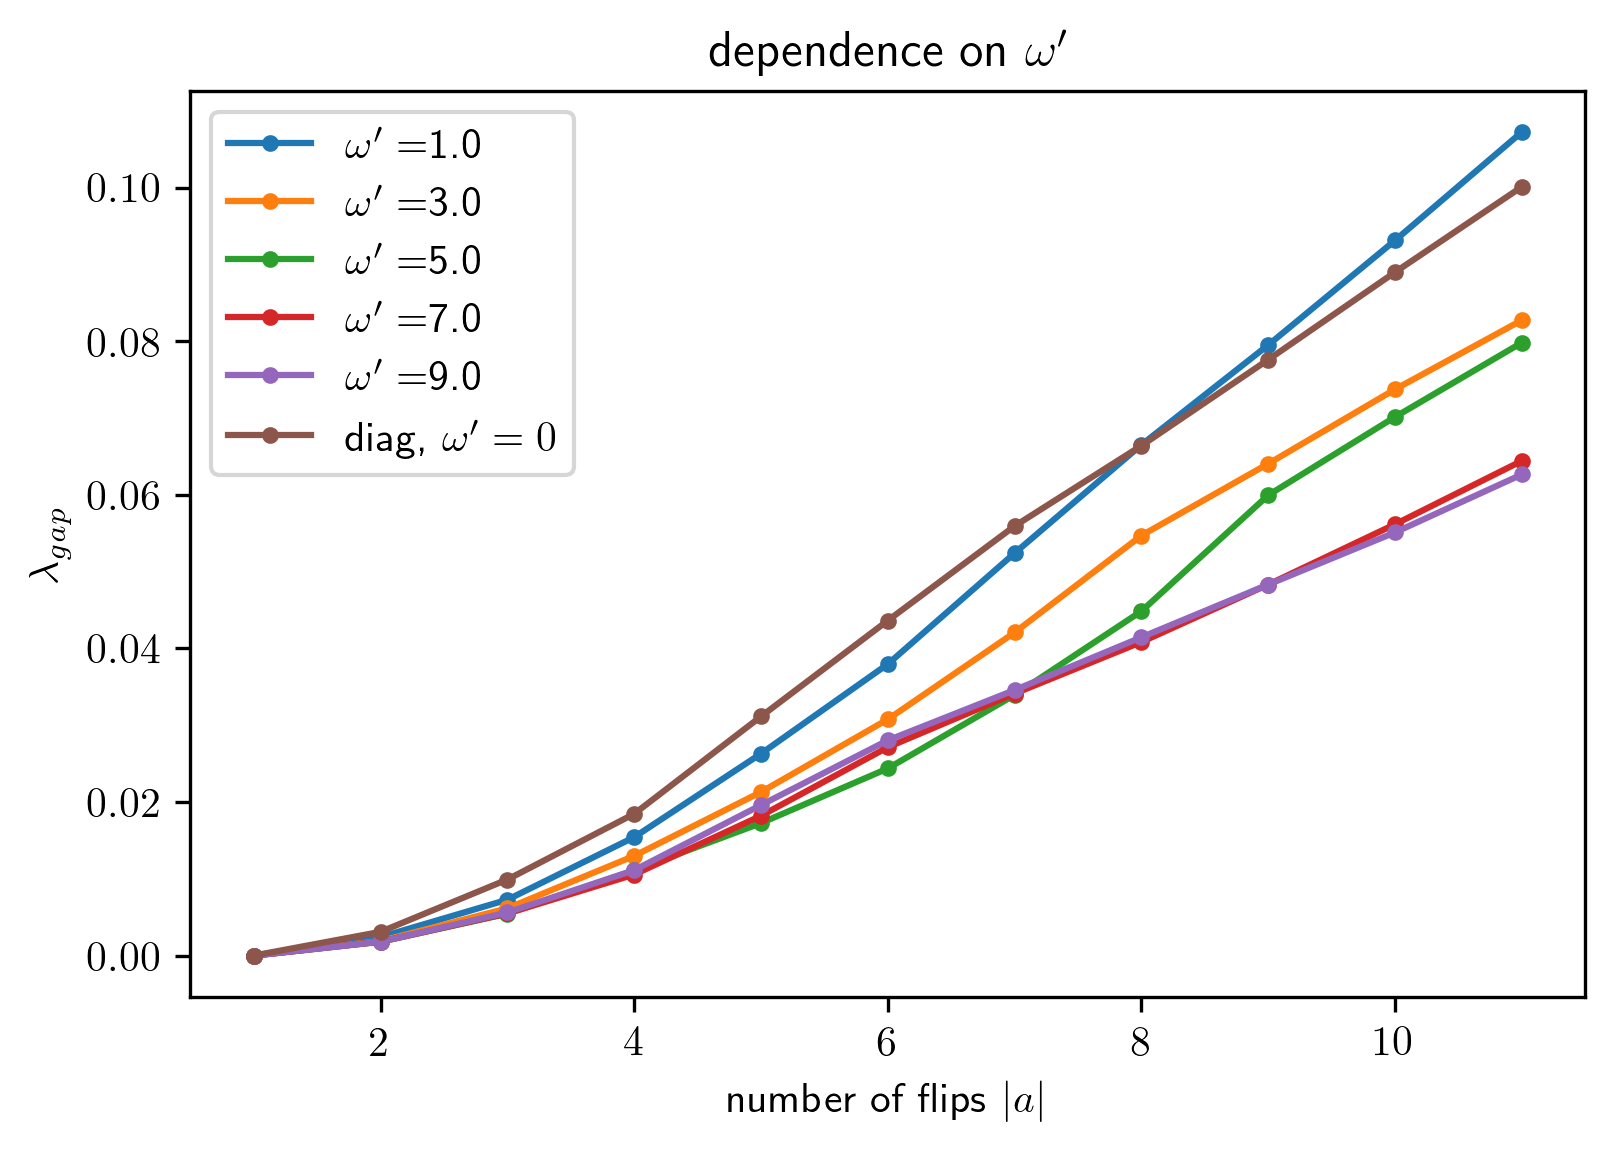

In [17]:
# Off-diagonal inputs: omega' dependence
plt.figure(dpi=300)

for omega_ in [1,3,5,7,9]:
    g1 = 0.9045  
    h1 = 0.8090 
    J = 1
    L = 11
    H = ghHamiltonian(g1,h1,L)
    nu0 = 0.4
    omega = 1
    
    nu1 = 0
    nu11 = nu1+nu0
    nu2 = nu1 + omega
    nu22 = nu2+nu0

    nu_1 = nu1 +omega_
    nu_11 = nu_1+nu0
    nu_2 = nu_1+omega
    nu_22 = nu_2+nu0

    w, v = LA.eigh( H )
    Pnu1 = Pnu( nu1,nu11,w,v)
    Pnu2 = Pnu(nu2,nu22,w,v)
    Pnu2H = Pnu2.conj().T
    print(nu1,nu11, np.shape(Pnu1)[1])
    print(nu2,nu22, np.shape(Pnu2)[1])

    Pnu_1 = Pnu( nu_1,nu_11,w,v)
    Pnu_2 = Pnu(nu_2,nu_22,w,v)
    Pnu_2H = Pnu_2.conj().T
    print(nu_1,nu_11, np.shape(Pnu_1)[1])
    print(nu_2,nu_22, np.shape(Pnu_2)[1])

    aary = np.linspace(1,L,num=L)
    lam = np.zeros(len(aary))
    for k in range(0,len(aary)):
        a=int(aary[k])
        A21 =[Pnu2H.dot(tensor(Sx, i,L).dot(Pnu1)) for i in range(1,a+1)]
        A_2_1 =[Pnu_2H.dot(tensor(Sx, i,L).dot(Pnu_1)) for i in range(1,a+1)]
        lam[k]=spec_offdiag_Lind_expand12(A21,A_2_1)[0]
    plt.plot(aary,lam,'.-', label=r"$\omega'=$%.1f"%omega_)


# Comparing with the diagonal inputs 
w, v = LA.eigh( H )
Pnu1 = Pnu( nu1,nu11,w,v)
Pnu2 = Pnu(nu2,nu22,w,v)
Pnu2H = Pnu2.conj().T
print(nu1,nu11, np.shape(Pnu1)[1])
print(nu2,nu22, np.shape(Pnu2)[1])

aary = np.linspace(1,L,num=L)
lam = np.zeros(len(aary))
for k in range(0,len(aary)):
    a=int(aary[k])
    A21 =[Pnu2H.dot(tensor(Sx, i,L).dot(Pnu1)) for i in range(1,a+1)]
    lam[k]=spec_Lind_expand12(A21)[1]

plt.plot(aary,lam,'.-', label = r"diag, $\omega'=0$")

plt.legend()
plt.title(r"dependence on $\omega'$")
plt.xlabel(r"number of flips $|a|$")
plt.ylabel(r"$\lambda_{gap}$")
plt.show()

In [ ]:
# Comparison with the `expected L'. 
# The expectation is supposedly taken over ETH, but here we model it by dropping the zero-mean terms manually.

In [15]:
# Comparing with the expectation (with diagonal inputs)

plt.figure(dpi=300)
g1 = 0.9045  
h1 = 0.8090 
J = 1
L = 11

H = ghHamiltonian(g1,h1,L)
nu0 = 0.4
omega = 1
nu1 = 0
nu11 = nu1+nu0
nu2 = nu1 + omega
nu22 = nu2+nu0

w, v = LA.eigh( H )
Pnu1 = Pnu( nu1,nu11,w,v)
Pnu2 = Pnu(nu2,nu22,w,v)
Pnu2H = Pnu2.conj().T
print(nu1,nu11, np.shape(Pnu1)[1])
print(nu2,nu22, np.shape(Pnu2)[1])

aary = np.linspace(3,L,num=L-2)
lam = np.zeros(len(aary))
lam_delta = np.zeros(len(aary))
for k in range(0,len(aary)):
    a=int(aary[k])
    A21 =[Pnu2H.dot(tensor3(Sx,Sx,Sx, i, j,k,L).dot(Pnu1)) for i in range(1,a+1) for j in range(i+1,a+1) for k in range(j+1,a+1)]
    lam[k]=Exp_Lind_expand12(A21)
    lam_delta[k]=delta_spec_Lind_expand12(A21)

0 0.4 64
1 1.4 57
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2


<Figure size 1800x1200 with 0 Axes>

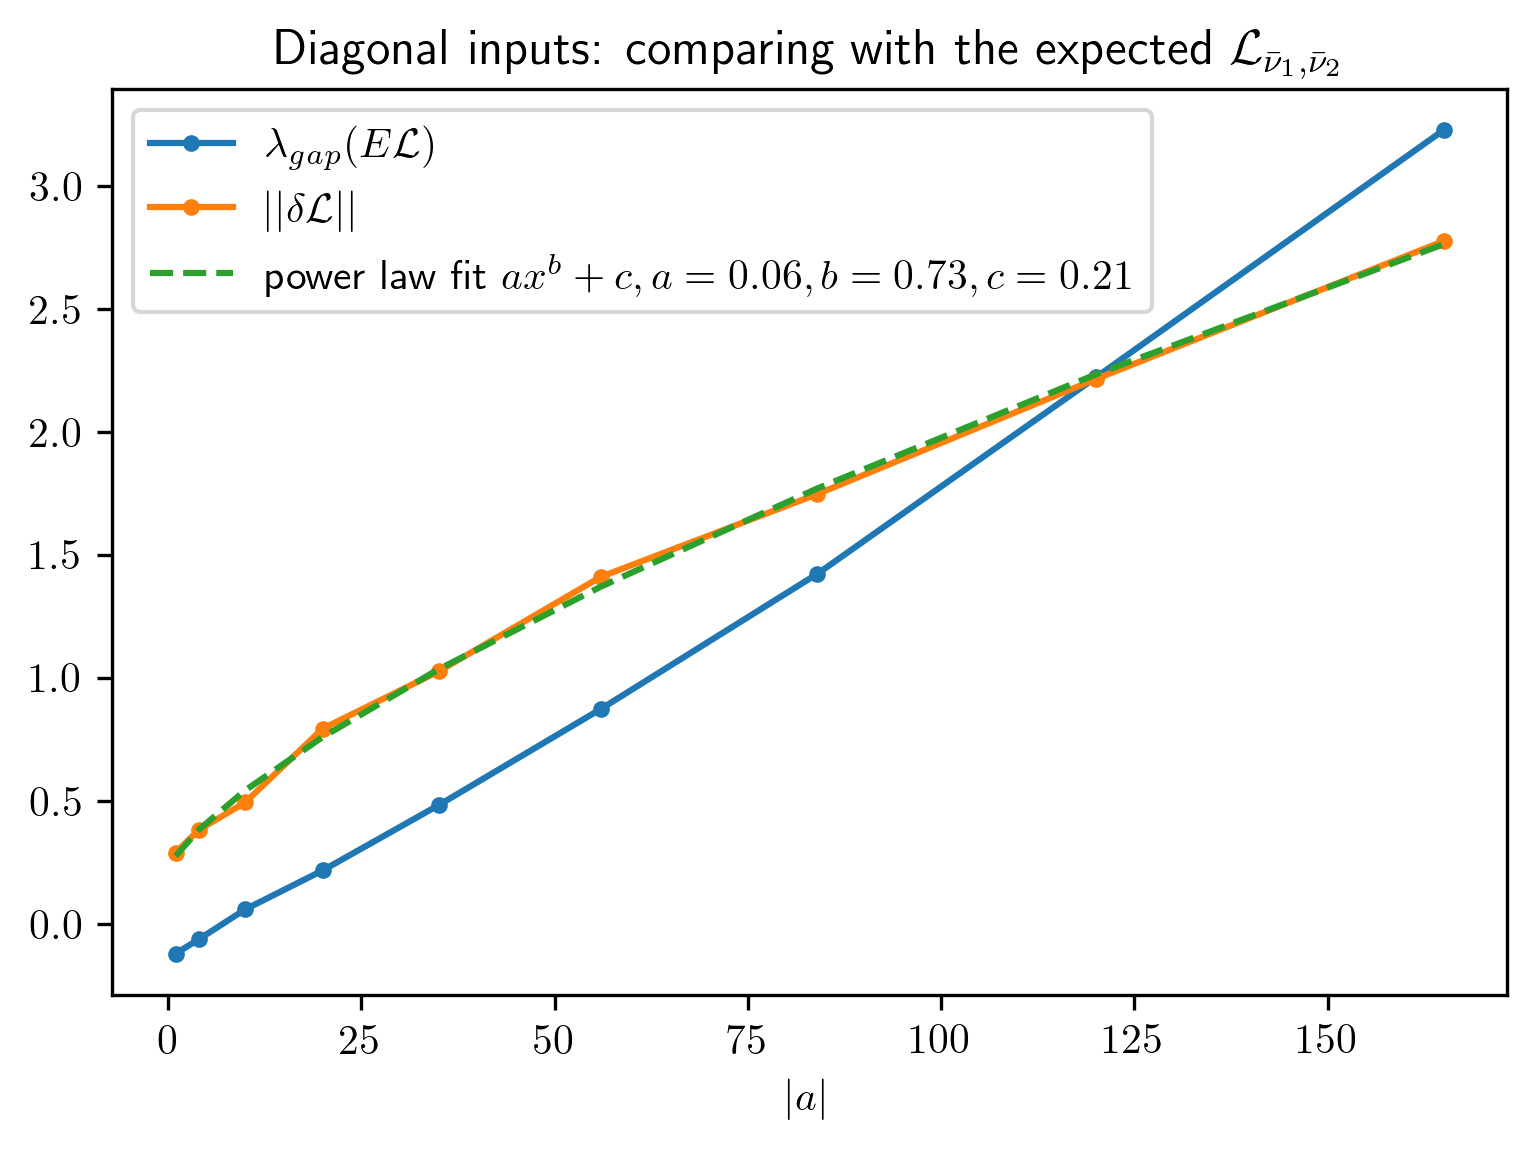

In [16]:
# Plotting the above
plt.figure(dpi=300)

x = 1/6*aary*(aary-1)*(aary-2)
y = lam_delta

def power_law(x, a, b,c):
    return a* (x**b) +c

params = curve_fit(power_law, x, y)
[a, b,c] = params[0]

plt.plot(1/6*aary*(aary-1)*(aary-2),lam,'.-', label=r'$\lambda_{gap}( \mathcal{L})$')
plt.plot(1/6*aary*(aary-1)*(aary-2),lam_delta,'.-', label=r'$||\delta \mathcal{L}||$')
plt.plot(1/6*aary*(aary-1)*(aary-2),power_law(x, a,b,c),'--', label=r'power law fit $ax^b+c,a= %.2f, b=%.2f, c=%.2f$' %(a,b,c) )
plt.title(r'Diagonal inputs: comparing with the expected $\mathcal{L}_{\bar{\nu}_1,\bar{\nu}_2}$')
plt.legend()
plt.xlabel(r"$|a|$")
plt.show()

In [6]:
# Comparing with the expectation, off-diagonal inputs
g1 = 0.9045  
h1 = 0.8090 
J = 1
L = 11

H = ghHamiltonian(g1,h1,L)
nu0 = 0.4
omega = 1
omega_ = 3
nu1 = 0
nu11 = nu1+nu0
nu2 = nu1 + omega
nu22 = nu2+nu0

nu_1 = nu1 +omega_
nu_11 = nu_1+nu0
nu_2 = nu_1+omega
nu_22 = nu_2+nu0

w, v = LA.eigh( H )
Pnu1 = Pnu( nu1,nu11,w,v)
print(nu1,nu11, np.shape(Pnu1)[1])
Pnu2 = Pnu(nu2,nu22,w,v)
print(nu2,nu22, np.shape(Pnu2)[1])
Pnu2H = Pnu2.conj().T

Pnu_1 = Pnu( nu_1,nu_11,w,v)
print(nu_1,nu_11, np.shape(Pnu_1)[1])
Pnu_2 = Pnu(nu_2,nu_22,w,v)
print(nu_2,nu_22, np.shape(Pnu_2)[1])
Pnu_2H = Pnu_2.conj().T

aary = np.linspace(3,L,num=L-2)
lam = np.zeros(len(aary))
lam_delta = np.zeros(len(aary))
for k in range(0,len(aary)):
    a=int(aary[k])
    A21 =[Pnu2H.dot(tensor3(Sx,Sx,Sx, i, j,k,L).dot(Pnu1)) for i in range(1,a+1) for j in range(i+1,a+1) for k in range(j+1,a+1)]
    A_2_1 =[Pnu_2H.dot(tensor3(Sx,Sx,Sx, i, j,k,L).dot(Pnu_1)) for i in range(1,a+1) for j in range(i+1,a+1) for k in range(j+1,a+1)]
    #A21 =[Pnu2H.dot(tensor(Sx, i,L).dot(Pnu1)) for i in range(1,a+1)]
    lam[k]=Exp_offdiag_Lind_expand12(A21,A_2_1)[0]
    lam_delta[k]=delta_spec_offdiag_Lind_expand12(A21,A_2_1)


0 0.4 64
1 1.4 57
3 3.4 55
4 4.4 39


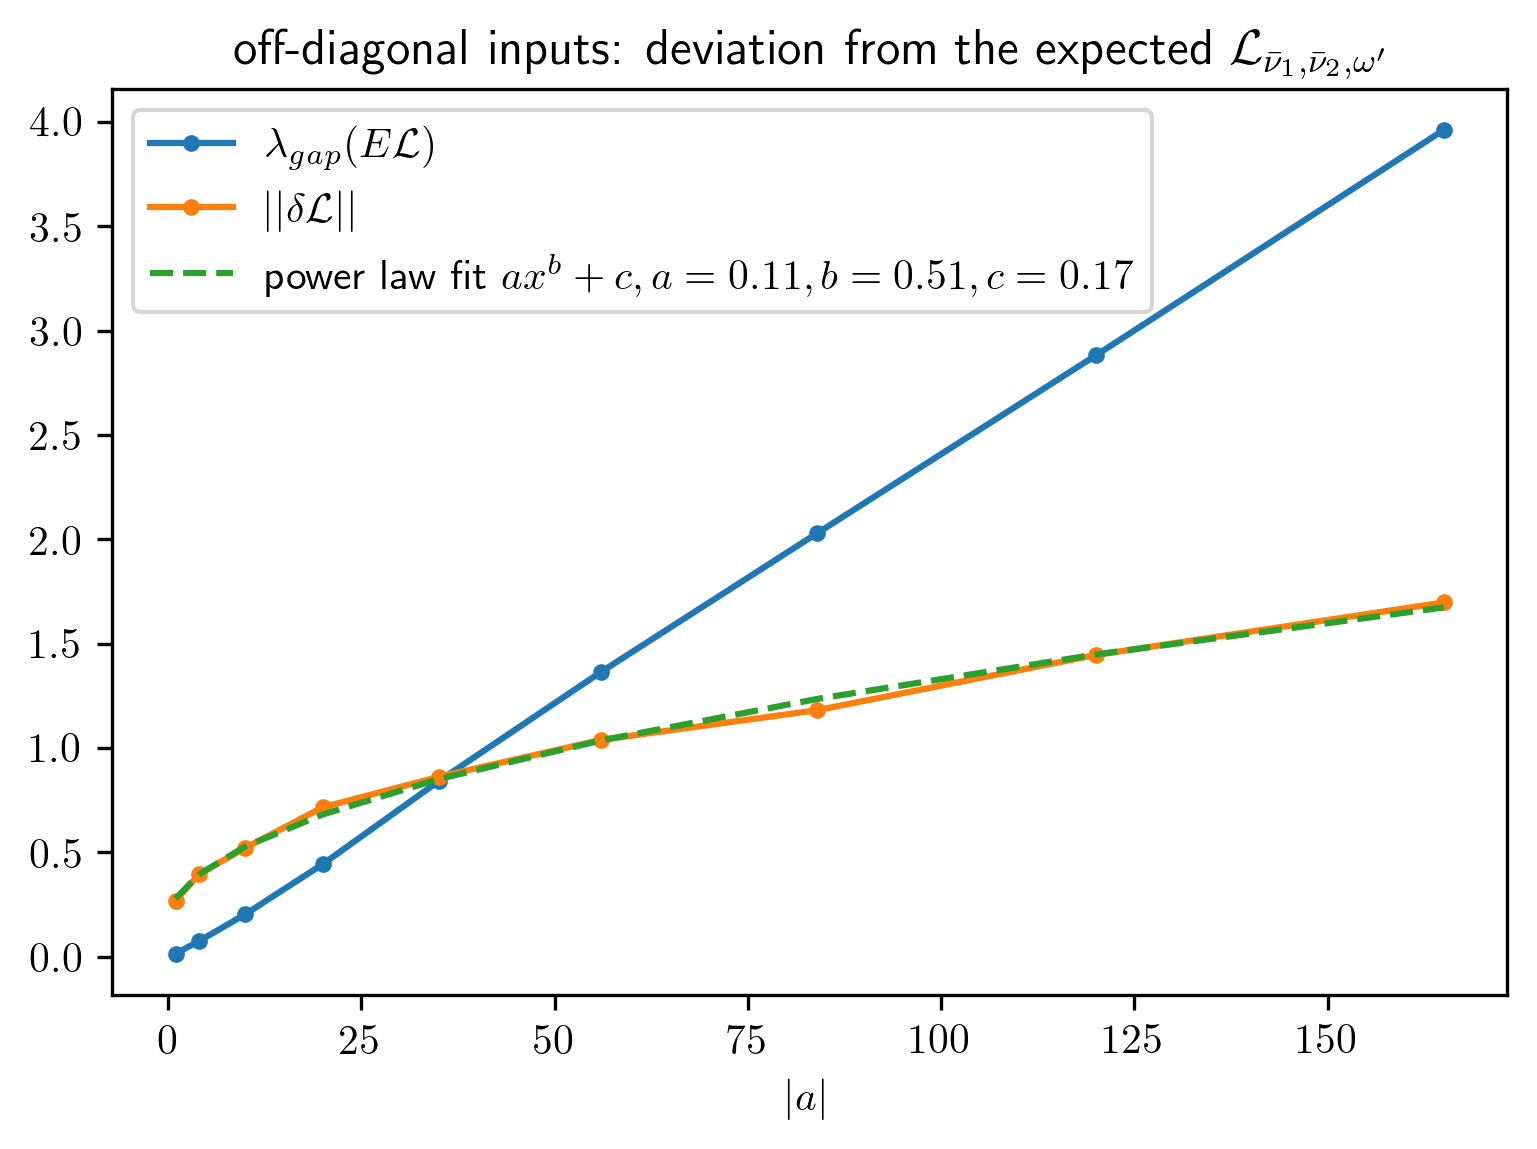

In [7]:
# Plotting the above
plt.figure(dpi=300)

x = 1/6*aary*(aary-1)*(aary-2)
y = lam_delta

def power_law(x, a, b,c):
    return a* (x**b) +c

params = curve_fit(power_law, x, y)
[a, b,c] = params[0]

plt.plot(1/6*aary*(aary-1)*(aary-2),lam,'.-', label=r'$\lambda_{gap}(E \mathcal{L})$')
plt.plot(1/6*aary*(aary-1)*(aary-2),lam_delta,'.-', label=r'$||\delta \mathcal{L}||$')
plt.plot(1/6*aary*(aary-1)*(aary-2),power_law(x, a,b,c),'--', label=r'power law fit $ax^b+c,a= %.2f, b=%.2f, c=%.2f$' %(a,b,c) )
plt.title(r"off-diagonal inputs: deviation from the expected $\mathcal{L}_{\bar{\nu}_1,\bar{\nu}_2,\omega'}$")
plt.legend()
plt.xlabel(r"$|a|$")
plt.show()